In [185]:
import pandas as pd

from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertForQuestionAnswering, TFBertForNextSentencePrediction

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.optimizers import Adam

In [2]:
train = 'train.csv'
test = 'test.csv'
sub = 'sample_submission.csv'

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
sentences = df.text.values
labels = df.target.values

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

X = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    X.append(encoded_sent)


In [7]:
# We'll borrow the `pad_sequences` utility function to do this.


# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 35

X = pad_sequences(X, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [8]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
X_train, X_test, y_train, y_test = train_test_split(X, labels, 
                                                            random_state=42, test_size=0.1)

In [9]:

model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

In [14]:
loss_classif     =  'binary_crossentropy'# find the right loss for multi-class classification
optimizer        =  Adam(1e-5, 1e-8) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

In [15]:
bs = 32
n_epochs = 10
#, batch_size=bs
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_test, y_test))

Train on 6851 samples, validate on 762 samples
Epoch 1/10
6851/6851 [==============================] - 76s 11ms/sample - loss: 0.3872 - accuracy: 0.8736 - val_loss: 0.6063 - val_accuracy: 0.8123
Epoch 2/10
 736/6851 [==>...........................] - ETA: 43s - loss: 0.3427 - accuracy: 0.8935

KeyboardInterrupt: 

In [24]:
pred1 = model.predict(X_test)
pred1 = pred1.reshape(pred1.shape[0])

In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.7964071856287424

In [362]:
model = TFBertForQuestionAnswering.from_pretrained('bert-base-uncased')
# model = TFBertForNextSentencePrediction.from_pretrained('bert-base-uncased')

In [363]:
sent = "how old are you? I am seventeen years old and i brush my teeth every morning"

if sent[-1] != '.' and sent[-1] != '!' and sent[-1] != '?':
    sent += '.'
    
sent = '[CLS] ' + sent.replace('?','.').replace('!','.').replace('.', ' [SEP]')    
sent

'[CLS] how old are you [SEP] I am seventeen years old and i brush my teeth every morning [SEP]'

In [364]:
n = 0
mask = []
for elt in sent.split(' '):
    mask.append(n)
    if elt == '[SEP]':
        n = (n+1)%2

MAX_LEN = 35

tok = sent.split(' ')
size = len(tok)
while len(tok) < MAX_LEN:
    tok.append('0')
    mask.append(0)

mask = np.array(mask)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

sent = tokenizer.encode(       sent,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                   )

sent = pad_sequences([sent], maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")[0]

rep = model((sent.reshape(1,MAX_LEN), mask.reshape(1,MAX_LEN)))

In [371]:
rep = np.array(rep)

In [372]:
rep[0]

array([[ 0.24641   ,  0.12467587,  0.00346245,  0.07411773,  0.05342459,
        -0.3276493 ,  0.17138776,  0.12592848,  0.2797534 , -0.12854463,
         0.05239046,  0.3852054 ,  0.10357419,  0.27241296,  0.04506567,
         0.2907193 ,  0.24388483,  0.08618672, -0.33468193,  0.15796256,
         0.1326283 ,  0.04823269,  0.02373403,  0.03150954,  0.05413393,
         0.14868936,  0.08825776,  0.15054755,  0.0528098 ,  0.08900872,
         0.11606022, -0.07944335,  0.11575027,  0.06591807,  0.0809508 ]],
      dtype=float32)

([<matplotlib.axis.XTick at 0x23f6b679588>,
 <a list of 19 Text xticklabel objects>)

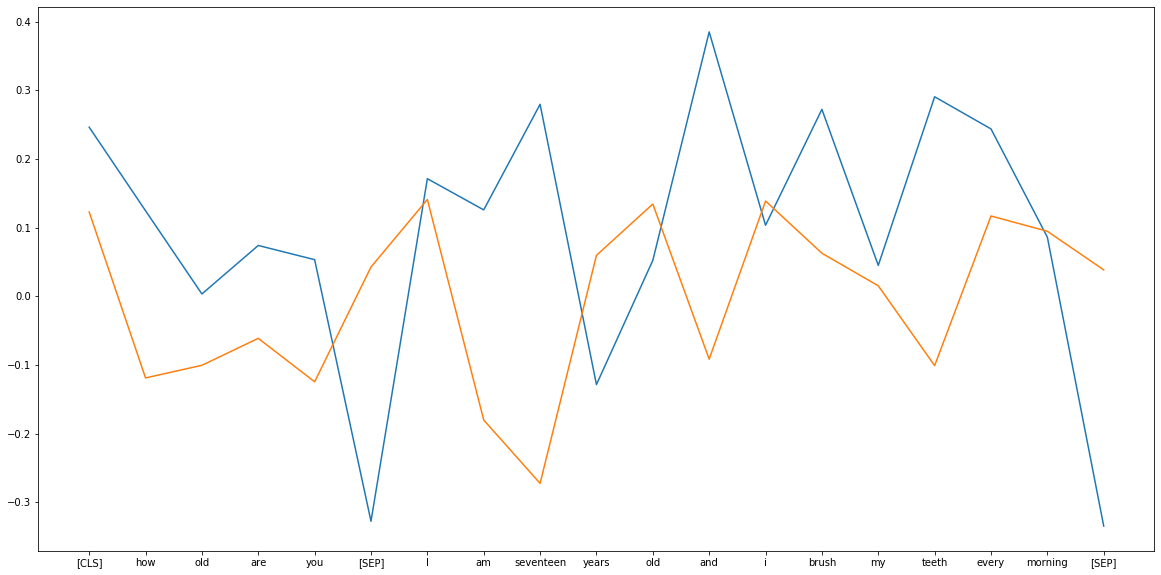

In [373]:

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))
plt.plot(range(size), rep[0][0][:size])
plt.plot(range(size), rep[1][0][:size])
plt.xticks(np.arange(size),tok[:size])